In [1]:
import cv2 as cv
import numpy
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sam_checkpoint = r"./sam_vit_b.pth"  # need to modify
model_type = "vit_b"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
image_path = r"./assets/example-image.jpg"  # need to modify

In [5]:
image = cv.imread(image_path)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

In [6]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [7]:
def segment_image(image, segmentation_mask):
  seg_mask = np.array([segmentation_mask, segmentation_mask, segmentation_mask]).transpose(1,2,0)
  return np.multiply(image, seg_mask)

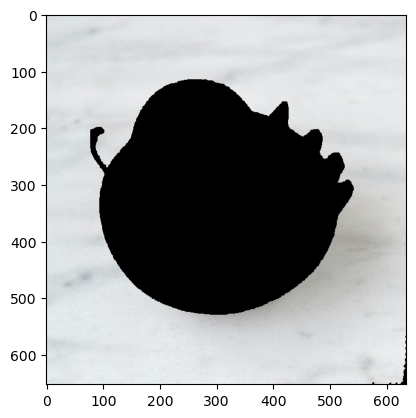

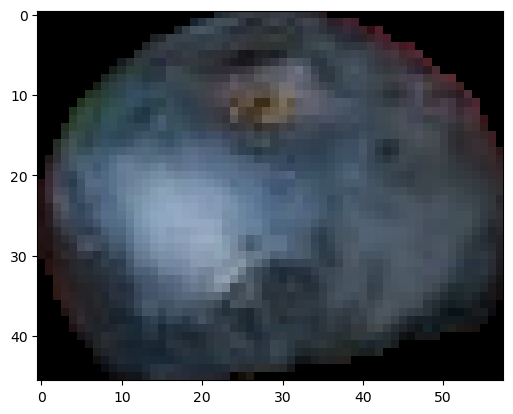

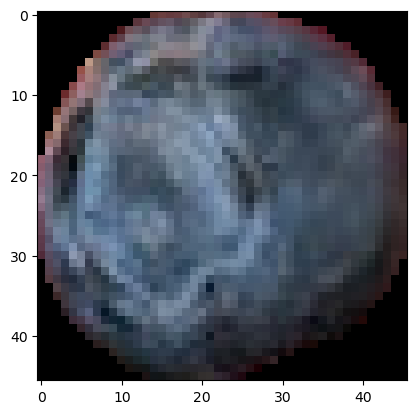

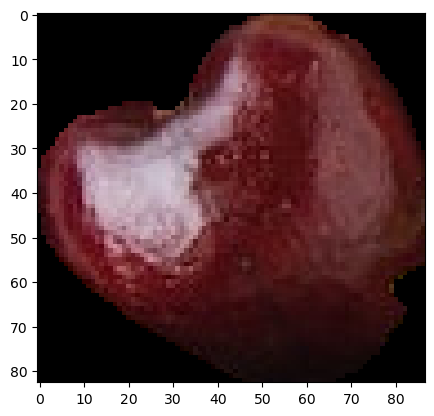

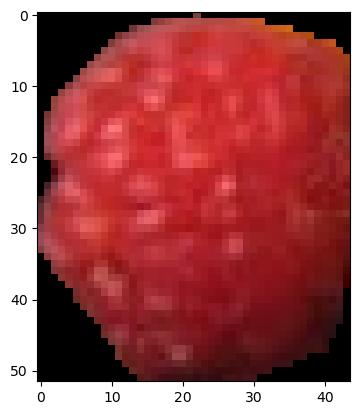

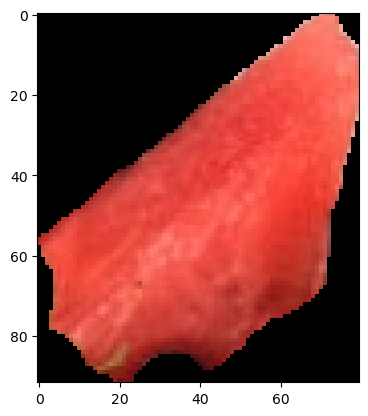

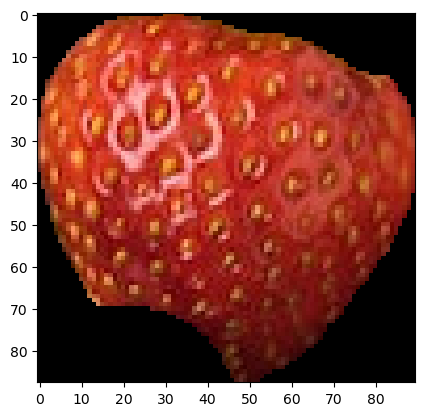

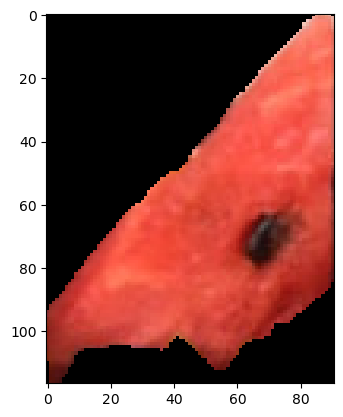

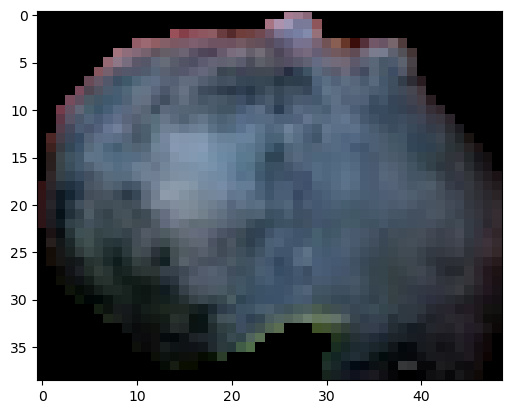

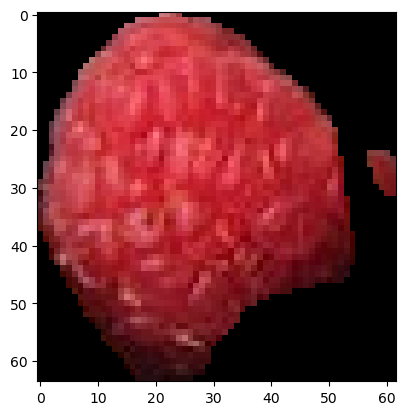

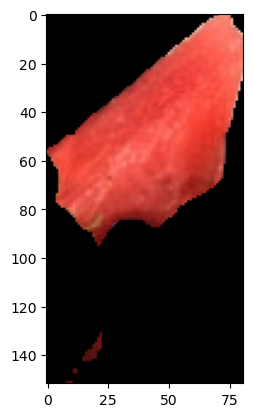

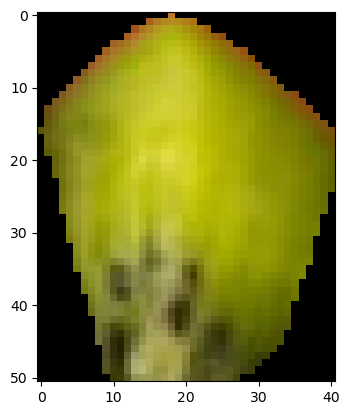

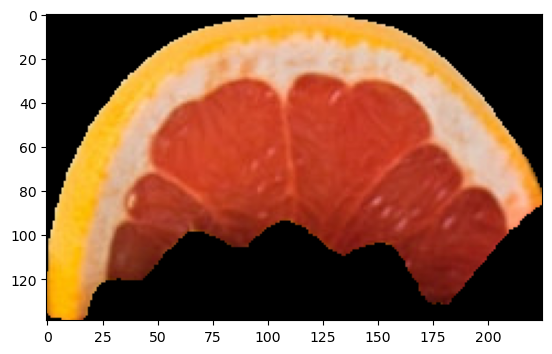

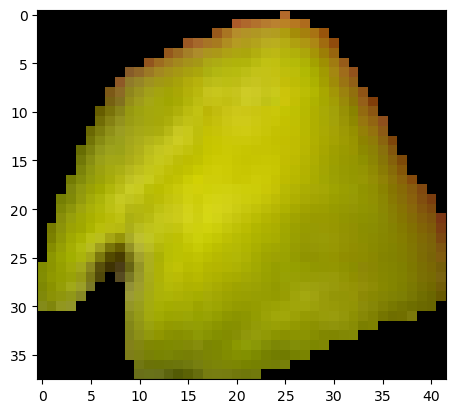

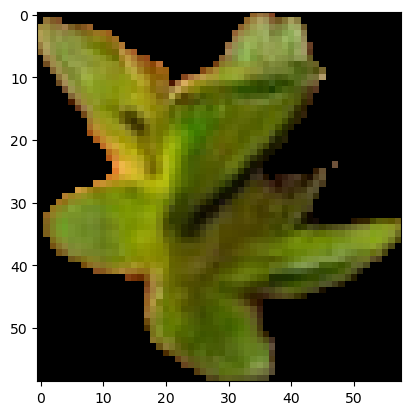

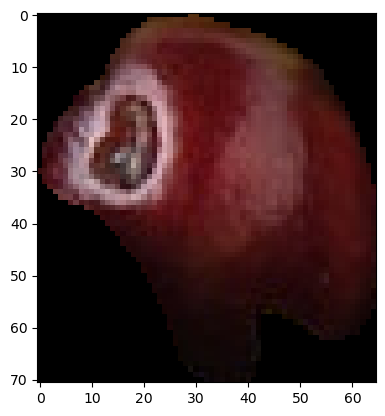

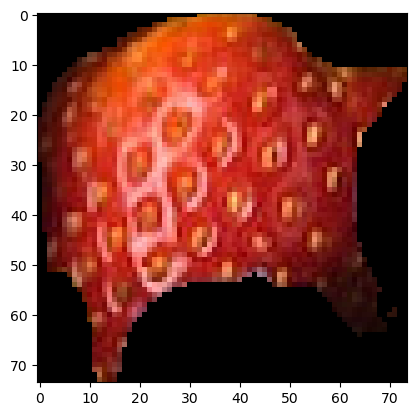

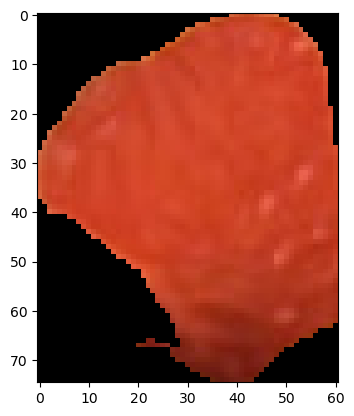

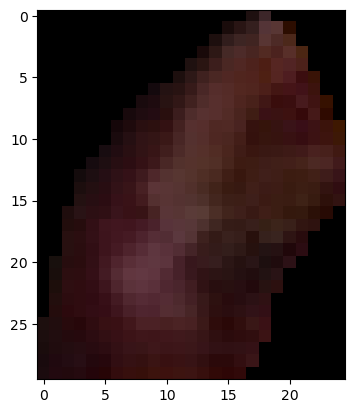

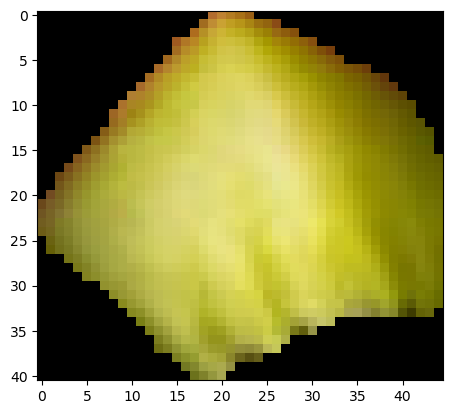

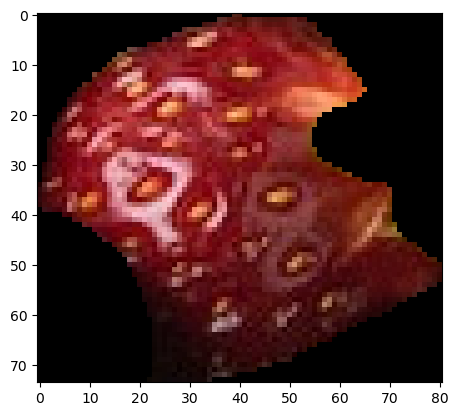

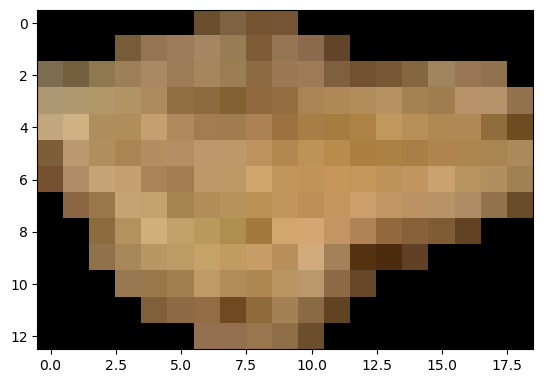

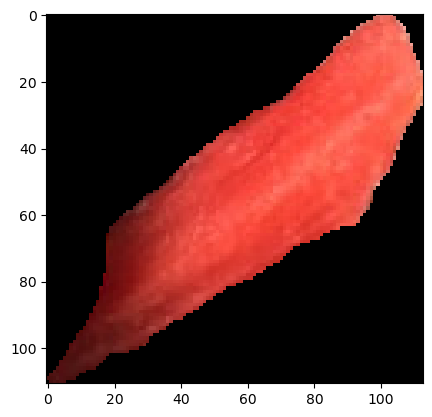

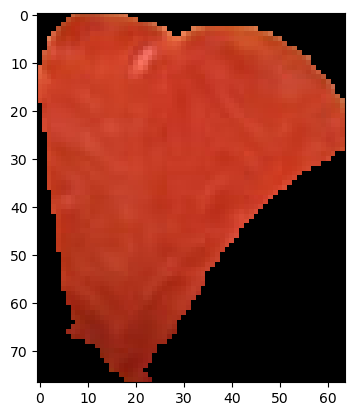

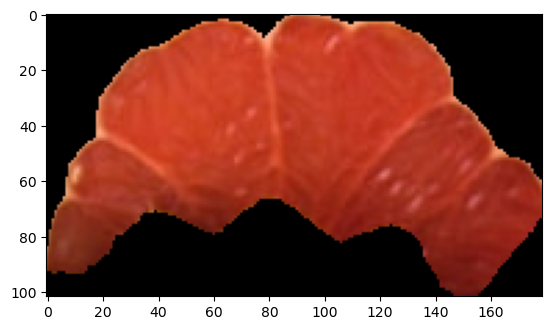

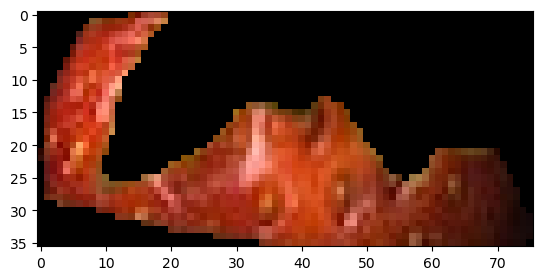

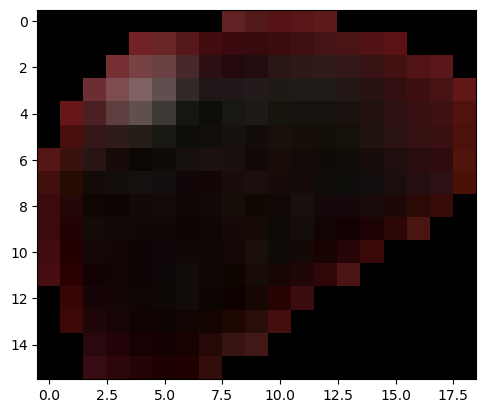

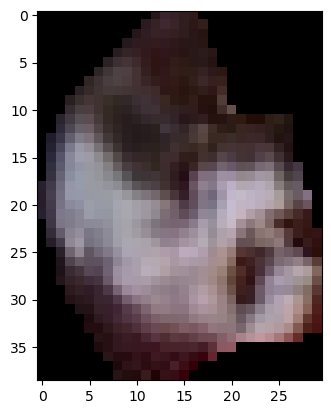

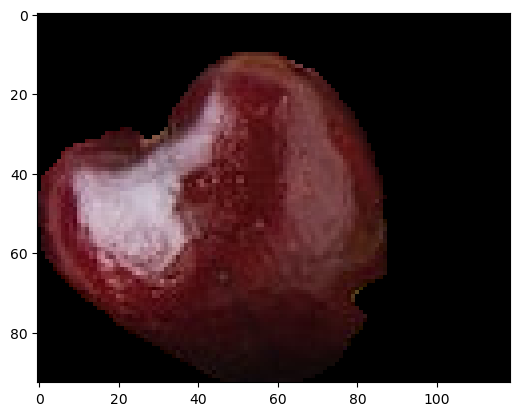

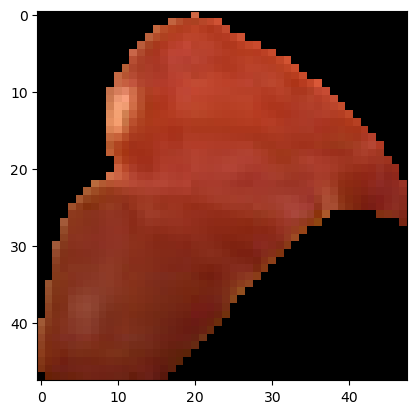

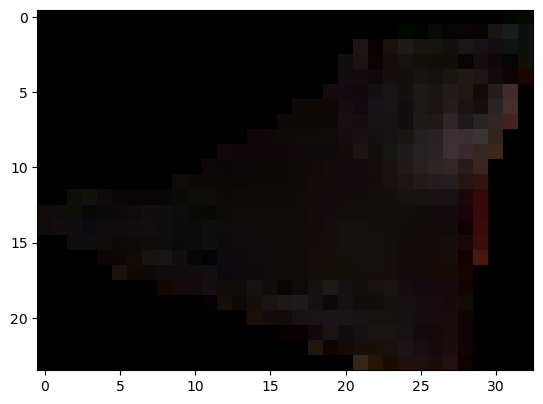

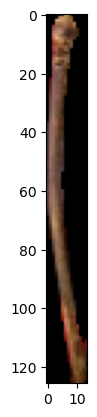

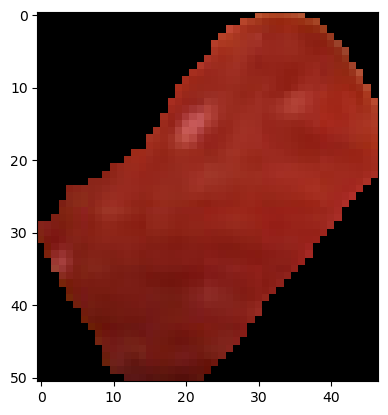

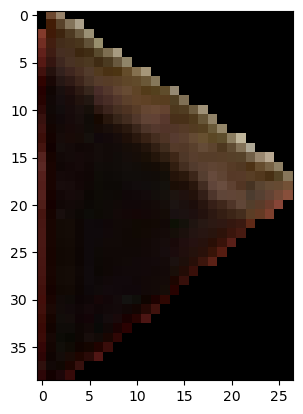

In [8]:
cropped_boxes = []
for mask in masks:
    x1, y1, x2, y2 = convert_box_xywh_to_xyxy(mask["bbox"])
    cropped_boxes.append(segment_image(image, mask["segmentation"]).astype("int")[y1:y2, x1:x2])
    plt.imshow(segment_image(image, mask["segmentation"]).astype("int")[y1:y2, x1:x2])
    plt.show()

In [9]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("./ViT-B-32.pt", device=device)  # need to modify

In [10]:
@torch.no_grad()
def retriev(elements, search_text):
    preprocessed_images = [preprocess(image.astype(dtype=np.uint8)).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [11]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

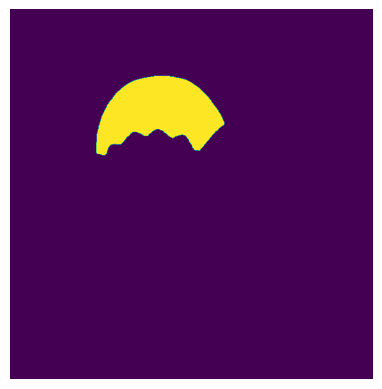

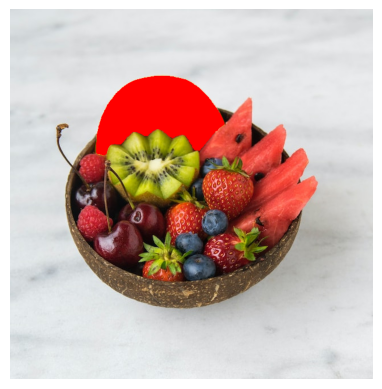

In [12]:
scores = retriev(cropped_boxes, "orange")
indices = get_indices_of_values_above_threshold(scores, 0.05)

segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = masks[seg_idx]["segmentation"].astype('uint8') * 255
    plt.imshow(segmentation_mask_image)
    plt.axis('off')
    plt.show()
    segmentation_masks.append(segmentation_mask_image)

seg_image = image.copy()
for segmentation_mask_image in segmentation_masks:
    seg_image[segmentation_mask_image > 0] = [255, 0, 0]

plt.imshow(seg_image)
plt.axis('off')
plt.show()